In [1]:
import scipy
import numpy as np
import numpy.linalg as LA
from load_mnist import loadImageSet, loadLabelSet

%matplotlib inline
import pylab
import matplotlib.pyplot as plt
from sklearn import neighbors
import pdb


In [66]:
#### Options
class Options(object):
    K = 50
    d = 39
    KNN_neighbor = 1
options = Options()    

# 数据加载

In [4]:
import scipy.io as sio

#matlab文件名
matfn=u'face_data/ORL/ORL_32x32.mat'
data=sio.loadmat(matfn)
face = data['fea']
label = data['gnd'] - 1 ### python 从0 开始
face = (face - face.min()) / float(face.max()-face.min())

#### 显示第一张图像
f1 = face[5].reshape((32,32)).T
pylab.imshow(f1, cmap=plt.cm.gray), pylab.show()

###  l = 3, randomsplit = 2
matfn = u'face_data/ORL/3Train/2.mat'
index = sio.loadmat(matfn)
testIdx = index['testIdx'] -1    ### python 从0 开始
trainIdx = index['trainIdx'] -1  ### python 从0 开始

train_face = face[trainIdx]
test_face = face[testIdx]
train_face = np.squeeze(train_face)  ## 将维度为1去掉
test_face = np.squeeze(test_face)    ## 将维度为1去掉
train_face = train_face.T ### 将数据维度变为: 样本维度 x 样本个数
test_face = test_face.T ### 将数据维度变为: 样本维度 x 样本个数
train_label = np.squeeze(label[trainIdx])
test_label = np.squeeze(label[testIdx])

In [126]:
#### BaseLine
clf = neighbors.KNeighborsClassifier(algorithm='auto',n_neighbors=1, weights= 'distance')  
clf.fit(train_face.T, train_label) 
"""测试准确率"""
acc = np.float(sum(test_label==clf.predict(test_face.T))) / len(test_label)
print acc

0.8


# 可视化函数

In [9]:
#%%
# 将降维后的数据可视化,2维
def plot_embedding_2d(X, y, title=None):
    #坐标缩放到[0,1]区间
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)

    #降维后的坐标为（X[i, 0], X[i, 1]），在该位置画出对应的digits
    fig = plt.figure()
#     plt.axis([-2000, 2000,-2000,2000])
    ax = fig.add_subplot(1, 1, 1)
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1],str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if title is not None:
        plt.title(title)
#         plt.savefig(title.replace(' ','_')+".png") 

# 进行NPE降维需要的函数

In [10]:
def EuclideanDistances(A, B):
    BT = B.transpose()
    # vecProd = A * BT
    vecProd = np.dot(A,BT)
    # print(vecProd)
    SqA =  A**2
    # print(SqA)
    sumSqA = np.matrix(np.sum(SqA, axis=1))
    sumSqAEx = np.tile(sumSqA.transpose(), (1, vecProd.shape[1]))
    # print(sumSqAEx)

    SqB = B**2
    sumSqB = np.sum(SqB, axis=1)
    sumSqBEx = np.tile(sumSqB, (vecProd.shape[0], 1))    
    SqED = sumSqBEx + sumSqAEx - 2*vecProd
    SqED[SqED<0]=0.0   
    ED = np.array(np.sqrt(SqED))
    return ED

In [11]:
def get_neighbors_ind(X, K=10):
    """
    Param:
        X: M * N matrix
        Y: matrix
        K: The number of neighbors of each point
    """    
#     M, N = X.shape
#     X2 = np.sum(X**2, axis=0, keepdims=True)
#     distance = np.tile(X2,(N,1))+np.tile(X2.T,(1,N))-2 * np.matmul(X.T, X)
    distance = EuclideanDistances(X.T, X.T)
    index = np.argsort(distance, axis=0)
    neighborhood = index[1:(1+K),:]                                    
    return neighborhood

In [12]:
def get_neighbors_ind2(X, K=10):
    """
    Param:
        X: M * N matrix
        Y: matrix
        K: The number of neighbors of each point
    """    
    M, N = X.shape
    X2 = np.sum(X**2, axis=0, keepdims=True)
    distance = np.tile(X2,(N,1))+np.tile(X2.T,(1,N))-2 * np.matmul(X.T, X)
#     distance = EuclideanDistances(X.T, X.T)
    index = np.argsort(distance, axis=0)
    neighborhood = index[1:(1+K),:]                                    
    return neighborhood

In [13]:
def get_weight(X, neighborhood):
    M, N = X.shape
    K = neighborhood.shape[0]
    if K > M:
        tol=1e-3
    else:
        tol=0
    W = np.zeros((N, N))
    for i in xrange(N):
        z = X[:,neighborhood[:,i]] - np.expand_dims(X[:,i], 1)
        G = np.matmul(z.T, z)
        G = G + np.identity(K) * tol * np.trace(G)
        
        G_I = LA.inv(G)
        W[i,neighborhood[:,i]] = np.matmul(G_I, np.ones(K))  # np.matmul(G_I, np.ones(K)) 的结果是一个列向量，我们将其放在W的行中
        W[i,neighborhood[:,i]] = W[i, neighborhood[:,i]] / np.sum(W[i,:])  
#         W[:,i]=np.sum(G_I, axis=1) / np.sum(G_I)
    return W   

In [14]:
def get_M(W):
    N = W.shape[1]
    I = np.identity(N)
    M = np.matmul((I-W.T),(I-W))
    return M

In [15]:
def get_projections2(X, M):
    L = np.matmul(np.matmul(X, M), X.T)
    D = np.matmul(X, X.T)
    eigenvalue, eigenvector_right = scipy.linalg.eig(L, D)
    eigValInd=np.argsort(eigenvalue)
    eigenvector_right = eigenvector_right[:,eigValInd]
    return eigenvector_right

In [16]:
def get_U(X):
    r = np.linalg.matrix_rank(X)
    U, S, V = LA.svd(X, full_matrices=True)
    U = U[:,0:r]
    return U

In [21]:
def get_projections(X, M):
    #######这里先进行SVD分解会得到更好的效果
    r = np.linalg.matrix_rank(np.matmul(X, X.T))
#     if r < min(X.shape):  #### if XX^{T}是奇异矩阵
    U = get_U(X)
    X_tilde = np.matmul(U.T, X)
    L = np.matmul(np.array(np.matrix(np.matmul(X_tilde, X_tilde.T)).I), np.matmul(np.matmul(X_tilde, M), X_tilde.T))
    eigenValues, eigenVectors = LA.eig(L)
    eigValInd=np.argsort(eigenValues)
    eigenVectors = eigenVectors[:,eigValInd]
    return np.matmul(eigenVectors.T, U.T)
#     else:                               #### if XX^{T}是非奇异矩阵
#         L = np.matmul(np.array(np.matrix(np.matmul(X, X.T)).I), np.matmul(np.matmul(X, M), X.T))
#         eigenValues, eigenVectors = LA.eig(L)
#         eigValInd=np.argsort(eigenValues)
#         eigenVectors = eigenVectors[:,eigValInd]
#         return eigenVectors.T 

# NPE降维

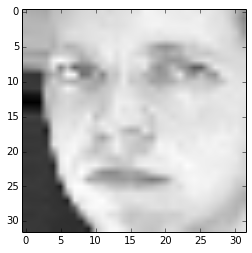

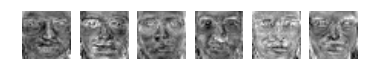

0.734375


In [145]:
import scipy.io as sio

#matlab文件名
matfn=u'face_data/ORL/ORL_32x32.mat'
data=sio.loadmat(matfn)
face = data['fea']
label = data['gnd'] - 1 ### python 从0 开始
face = (face - face.min()) / float(face.max()-face.min())

#### 显示第一张图像
f1 = face[5].reshape((32,32)).T
pylab.imshow(f1, cmap=plt.cm.gray), pylab.show()

###  l = 2, randomsplit = 1
matfn = u'face_data/ORL/2Train/5.mat'
index = sio.loadmat(matfn)
testIdx = index['testIdx'] -1    ### python 从0 开始
trainIdx = index['trainIdx'] -1  ### python 从0 开始

train_face = face[trainIdx]
test_face = face[testIdx]
train_face = np.squeeze(train_face)  ## 将维度为1去掉
test_face = np.squeeze(test_face)    ## 将维度为1去掉
train_face = train_face.T ### 将数据维度变为: 样本维度 x 样本个数
test_face = test_face.T ### 将数据维度变为: 样本维度 x 样本个数
train_label = np.squeeze(label[trainIdx])
test_label = np.squeeze(label[testIdx])


options.K = 49
options.d = 39
train_x_neighbor = get_neighbors_ind(train_face, K=options.K)
W = get_weight(train_face, train_x_neighbor)
W = np.maximum(W, W.T)
M = get_M(W)
M = np.maximum(M, M.T)
projections = get_projections(train_face, M)[0:options.d, :]

fig = pylab.figure()
for i in range(6):
    p = projections[i].reshape((32,32)).T
    fig.add_subplot(1, 6, i+1)
    pylab.imshow(p, cmap=plt.cm.gray)
    pylab.axis('off') 
pylab.show()
   
pylab.imsave('NPE_face0',p, cmap=plt.cm.gray)
embedding_train = np.matmul(projections, train_face)
embedding_test = np.matmul(projections, test_face)
''''' 训练KNN分类器 '''  
clf = neighbors.KNeighborsClassifier(algorithm='auto',n_neighbors=options.KNN_neighbor, weights= 'distance')  
clf.fit(embedding_train.T, train_label) 

"""测试准确率"""
acc = np.float(sum(test_label==clf.predict(embedding_test.T))) / len(test_label)
print acc

In [123]:
fig.savefig('test.png')

In [25]:
#### BaseLine
clf = neighbors.KNeighborsClassifier(algorithm='auto',n_neighbors=1, weights= 'distance')  
clf.fit(train_face.T, train_label) 
"""测试准确率"""
acc = np.float(sum(test_label==clf.predict(test_face.T))) / len(test_label)
print acc

0.6875
